# 6. Приближённое решение краевой задачи для обыкновенного дифференциального уравнения

Требуется найти приближённое решение краевой задачи для обыкновенного дифференциального уравнения на отрезке \([0, 1]\) с шагом \(h = 0.05\). Для вычисления решения необходимо использовать **метод прогонки** с краевыми условиями первого и второго порядка точности. Для сравнения приведено точное решение \(u_0(x)\).

$$
u'' + (\tan x)u' - \frac{2x}{\cos x}u = 2 - \frac{2x^3}{\cos x}
$$

$$
2u(0) - u'(0) = -1
$$
$$
3u(1) + u'(1) = 8.0647
$$

$$
u_0(x) = \sin x + x^2
$$

In [83]:
import numpy as np
import matplotlib.pyplot as plt

In [84]:
a, b = 0, 1
h = 0.05

In [85]:
def thomas_algorithm(a, b, c, d):
    n = len(d)
    if len(a) != n or len(b) != n or len(c) != n:
        raise ValueError("All input arrays must have the same length")

    a = a.copy()
    b = b.copy()
    c = c.copy()
    d = d.copy()

    for i in range(1, n):
        factor = a[i] / b[i-1]
        b[i] = b[i] - factor * c[i-1]
        d[i] = d[i] - factor * d[i-1]

    x = np.zeros(n)
    x[-1] = d[-1] / b[-1]

    for i in range(n-2, -1, -1):
        x[i] = (d[i] - c[i] * x[i+1]) / b[i]

    return x

In [ ]:
def solve_first_order(h):
    n = int(1/h)
    x = np.linspace(a, b, n+1)
    
    A = np.zeros(n+1)
    B = np.zeros(n+1)
    C = np.zeros(n+1)
    F = np.zeros(n+1)

    for i in range(1, n):
        A[i] = 1 - h * np.tan(x[i]) / 2
        B[i] = -2 - h**2 * (2*x[i] / np.cos(x[i]))
        C[i] = 1 + h * np.tan(x[i]) / 2
        F[i] = h**2 * (2 - (2*x[i]**3)/np.cos(x[i]))

    B[0] = 2 + 1/h
    C[0] = -1/h
    F[0] = -1

    A[n] = -1/h
    B[n] = 3 + 1/h
    F[n] = 8.0647

    u = thomas_algorithm(A, B, C, F)
    
    return x, u

def solve_second_order(h):
    n = int(1/h)
    x = np.linspace(0, 1, n+1)
    
    # Коэффициенты для внутренних точек (i=1,...,n-1)
    A = np.zeros(n+1)
    B = np.zeros(n+1)
    C = np.zeros(n+1)
    F = np.zeros(n+1)
    
    for i in range(1, n):
        A[i] = 1 - h * np.tan(x[i]) / 2
        B[i] = -2 - h**2 * (2*x[i] / np.cos(x[i]))
        C[i] = 1 + h * np.tan(x[i]) / 2
        F[i] = h**2 * (2 - (2*x[i]**3)/np.cos(x[i]))
    
    # Краевые условия второго порядка
    # Левое: 2u0 - u'(0) = -1
    c00 = 2 + 3/(2*h)
    c10 = -2/h
    c20 = 1/(2*h)
    f0 = -1
    
    # Правое: 3u_n + u'(1) = 8.0647
    c0n = 1/(2*h)
    c1n = -2/h
    c2n = 3 + 3/(2*h)
    fn = 8.0647
    
    # Выражаем u0 через u1 и u2
    # u0 = (f0 - c10*u1 - c20*u2) / c00
    
    # Преобразуем уравнение для i=1
    new_B1 = B[1] - A[1] * c10 / c00
    new_C1 = C[1] - A[1] * c20 / c00
    new_F1 = F[1] - A[1] * f0 / c00
    
    # Преобразуем последнее уравнение используя i=n-1
    new_Bn = c1n - c0n * B[n-1] / A[n-1]
    new_Cn = c2n - c0n * C[n-1] / A[n-1]
    new_Fn = fn - c0n * F[n-1] / A[n-1]
    
    # Создаем систему для u1,...,un
    size = n  # от 1 до n
    a = np.zeros(size+1)  # индексы 1..n
    b = np.zeros(size+1)
    c = np.zeros(size+1)
    d = np.zeros(size+1)
    
    # i=1
    a[1] = 0
    b[1] = new_B1
    c[1] = new_C1
    d[1] = new_F1
    
    # i=2..n-1
    for i in range(2, n):
        a[i] = A[i]
        b[i] = B[i]
        c[i] = C[i]
        d[i] = F[i]
    
    # i=n
    a[n] = new_Bn
    b[n] = new_Cn
    c[n] = 0
    d[n] = new_Fn
    
    # Решаем систему для u1..un
    alpha = np.zeros(size+1)
    beta = np.zeros(size+1)
    
    alpha[1] = -c[1] / b[1]
    beta[1] = d[1] / b[1]
    
    for i in range(2, n+1):
        denominator = b[i] + a[i] * alpha[i-1]
        alpha[i] = -c[i] / denominator
        beta[i] = (d[i] - a[i] * beta[i-1]) / denominator
    
    u_inner = np.zeros(size+1)
    u_inner[n] = beta[n]
    
    for i in range(n-1, 0, -1):
        u_inner[i] = alpha[i] * u_inner[i+1] + beta[i]
    
    # Восстанавливаем u0
    u0 = (f0 - c10 * u_inner[1] - c20 * u_inner[2]) / c00
    
    # Собираем полное решение
    u = np.zeros(n+1)
    u[0] = u0
    u[1:] = u_inner[1:]
    
    return x, u

In [ ]:
x = np.arange(a, b+h, h)
u0 = np.sin(x) + x**2

x_first, u_first = solve_first_order(h)
x_second, u_second = solve_second_order(h)

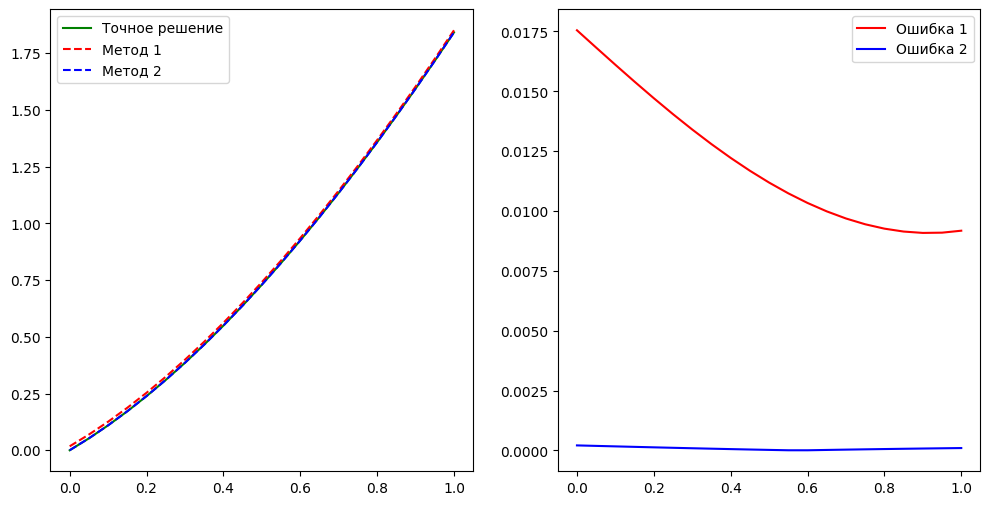

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(x_first, u0, label="Точное решение", c='g')
plt.plot(x_first, u_first, label="Метод 1", c='r', linestyle='--')
plt.plot(x_second, u_second, label="Метод 2", c='b', linestyle='--')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_first, abs(u0 - u_first), label="Ошибка 1", c='r')
plt.plot(x_second, abs(u0 - u_second), label="Ошибка 2", c='b')
plt.legend()

plt.show()